In [1]:
%matplotlib inline
import scipy.io
import numpy as np

from minisom import MiniSom
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

## Data Exploration

In [3]:
# Load Data
train_x = scipy.io.loadmat('train_data.mat')['data_train']
train_y = scipy.io.loadmat('train_label.mat')['label_train']
test_x = scipy.io.loadmat('test_data.mat')['data_test']

class_labels = np.unique(train_y)
# Print key stats
print(f'Input data Shape is: {train_x.shape}\nLabel data shape is: {train_y.shape}\nData has feature size of {train_x.shape[1]}')
print(f'Test data Shape is: {test_x.shape}')
print(f'\nMean of Train Data is: {train_x.mean():0.4f}\nStd Deviation of train data is: {train_x.std():0.4f}')
print(f'\nMean of Test Data is: {test_x.mean():0.4f}\nStd Deviation of test data is: {test_x.std():0.4f}')

print(f'\nTotal number of classes is: {len(class_labels)}\nClass labels are: {class_labels}')
print(f'\nData belonging to class 0: {(train_y==-1).sum()}\nData belonging to class 1: {(train_y==1).sum()}')

Input data Shape is: (330, 33)
Label data shape is: (330, 1)
Data has feature size of 33
Test data Shape is: (21, 33)

Mean of Train Data is: 0.0071
Std Deviation of train data is: 0.9955

Mean of Test Data is: -0.1109
Std Deviation of test data is: 1.0394

Total number of classes is: 2
Class labels are: [-1  1]

Data belonging to class 0: 116
Data belonging to class 1: 214


## Main functions and classes

In [267]:
# Helper functions
def exponential_decay(parameter, n, t1):
    if parameter >0.1: t1 = 1000/np.log(t1)
    return parameter * np.exp(-1 * n / t1)

def asymptotic_decay(parameter, t, max_iter):
    return parameter / (1+t/(max_iter/2))

def get_distance(x1, x2):
    out = (x1 - x2)**2
    out = out.sum()
    return np.sqrt(out)

In [271]:
# Class definition for SOM network
class MiniSomv2(MiniSom):       
    def random_weights_init(self, data):
        it = np.nditer(self._activation_map, flags=['multi_index'])
        
        while not it.finished:
            rand_i = np.random.randint(len(data))
            self._weights[it.multi_index] = data[rand_i]
            it.iternext()
        
    def update_converge(self, x, win, lr):
        winner = self._weights[win[0],win[1]]
        self._weights[win[0],win[1]] += (x - winner) * lr
       
    def converge(self, data, num_iteration, lr = 0.01, random=False):
        iterations =  np.arange(num_iteration) % len(data)
        if random: np.random.shuffle(iterations)
       
        for iteration in iterations:
            self.update_converge(data[iteration], self.winner(data[iteration]), lr = lr)
     
    def train(self, data, num_iteration, random=False):
        iterations =  np.arange(num_iteration) % len(data)
        if random: np.random.shuffle(iterations)
            
        for t, iteration in enumerate(iterations):
            self.update(data[iteration], self.winner(data[iteration]),
                        t, num_iteration)

In [270]:
# Class Definition for RBF network
class RBF:
    def __init__(self, X, y, centroids, sigma = 1.0):
        self.X, self.y, self.centroids, self.sigma = X, y, centroids, sigma
        
    def one_hot(self,x):
        arr = np.concatenate (((x == -1),(x == 1)), axis= 1)
        return arr.astype(int)

    def rbf(self, x, c):
        d = get_distance(x, c)
        return np.exp(-0.5 * (d**2) / self.sigma **2)

    def rbf_list(self, X, centroids):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c) for c in centroids])
        return np.array(RBF_list)
    
    def fit(self):
        RBF_X = self.rbf_list(self.X, self.centroids)
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.one_hot(self.y)
    
    def evaluate(self):
        # Evaluate RBF on training data
        preds = self.predict(self.X).reshape(330,1)
        diff = preds - self.y
        acc = (diff==0).sum() / len(diff)
        print(f'Accuracy on Training Data is: {acc*100:0.2f}%')
    
    def predict(self, data):
        rbf_data = self.rbf_list(data, self.centroids)
        preds = rbf_data @ self.w
        
        preds = np.argmax(preds, axis = 1)
        preds[preds==0] = -1

        return preds

## Setup and Results

In [308]:
np.random.seed(seed = 1337) #For reproducible results when performing random init and training. For random results, set seed = None
size = 4             # 4 by 4 SOM for 16 neurons

# Create, initialise, train, converge SOM
som = MiniSomv2(size, size, input_len = train_x.shape[1], 
                decay_function=exponential_decay,
                sigma=2.121, learning_rate=0.1) 
som.random_weights_init(train_x)
som.train(train_x, 1000, random = True) 
som.converge(train_x, 8000, lr = 0.01, random = True)

# Extract SOM outputs as 16 centre vectors
centroids = som.get_weights()
centroids = centroids.reshape(size**2,-1)

# Create, train and evaluate RBF network
rbfnet = RBF(train_x, train_y, centroids, sigma = 1)
rbfnet.fit()
rbfnet.evaluate()

Accuracy on Training Data is: 83.33%


In [318]:
# Saving weights and centre vectors
scipy.io.savemat('centroids.mat', {'centroids': centroids})
rbf_weights = rbfnet.w
scipy.io.savemat('rbf_weights.mat', {'rbf_weights': rbf_weights})

In [309]:
# Predict Labels on test data
test_pred = rbfnet.predict(test_x).reshape(-1)
print(test_pred)

[ 1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1]


## Data visualisation for SOM

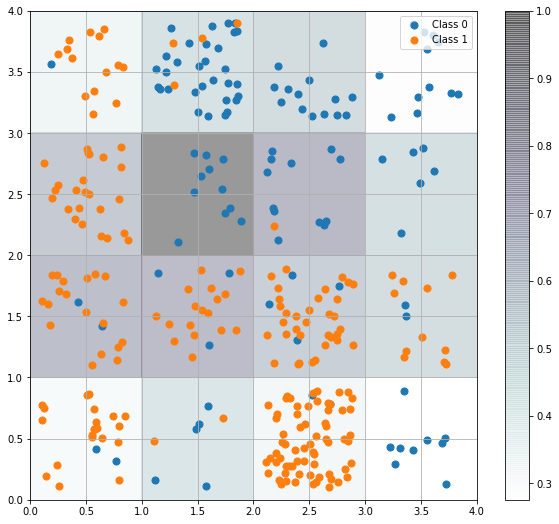

In [310]:
w_x, w_y = zip(*[som.winner(d) for d in train_x])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.4)
plt.colorbar()
colors = {-1:'C0', 1:'C1'}
label_names = {-1:'Class 0', 1:'Class 1'}


for c in np.unique(train_y):
    idx_target = train_y==c
    idx_target = idx_target.flatten().tolist()
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

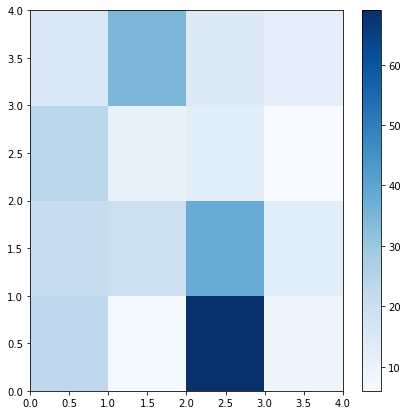

In [311]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(train_x)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

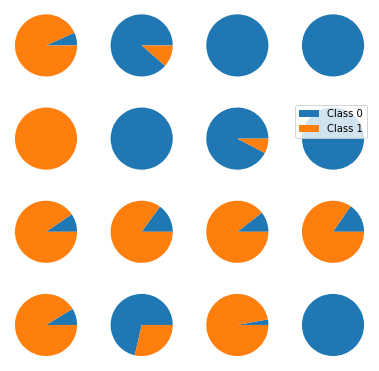

In [316]:
label_names = {-1:'Class 0', 1:'Class 1'}

labels_map = som.labels_map(train_x, [label_names[t[0]] for t in train_y])

fig = plt.figure(figsize=(10, 10))
the_grid = gridspec.GridSpec(6,6, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[6-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(),ncol=1)
plt.show()